In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statistics import NormalDist
from scipy.optimize import brentq

# -----------------------------
# 1. Setup and Constants
# -----------------------------
# Historical fitted smile coefficients
A = 0.237290
B = 0.002935
C = 0.149196

# Voucher strikes for each voucher product.
voucher_strikes = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500,
}

In [20]:


# Trading parameters
EXPIRY_DAY = 8  # Total days to expiry

# -----------------------------
# 2. Helper Functions
# -----------------------------
def bs_call_price(S, K, T, sigma, r=0.0):
    """Black-Scholes call option pricing."""
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return float("nan")
    d1 = (math.log(S / K) + 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * NormalDist().cdf(d1) - K * math.exp(-r * T) * NormalDist().cdf(d2)

def implied_volatility(S, K, T, market_price):
    """Compute implied volatility using Brent's method."""
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, sigma) - market_price, 1e-5, 5)
    except ValueError:
        return float("nan")

def iv_theory(m):
    """Return the theoretical IV from the fitted smile."""
    return A * m**2 + B * m + C

# -----------------------------
# 3. Load and Tag Data from All Days
# -----------------------------
# List the CSV files for day_0, day_1, day_2
csv_files = [
    "data/prices_round_3_day_0.csv",
    "data/prices_round_3_day_1.csv",
    "data/prices_round_3_day_2.csv"
]

df_list = []
for file in csv_files:
    # Extract day offset assuming filename contains "day_X.csv"
    day_str = file.split("_")[-1].split(".")[0]  # e.g., "0", "1", "2"
    day_offset = int(day_str)
    temp_df = pd.read_csv(file, sep=";")
    temp_df["day_offset"] = day_offset
    df_list.append(temp_df)

# Combine all files into one DataFrame.
df_all = pd.concat(df_list, ignore_index=True)

# Extract the spot data for VOLCANIC_ROCK.
spot_df = df_all[df_all["product"] == "VOLCANIC_ROCK"][["timestamp", "day_offset", "mid_price"]].copy()
spot_df = spot_df.rename(columns={"mid_price": "spot"})

# -----------------------------
# 4. Process Voucher Data
# -----------------------------
def process_voucher(voucher):
    """
    For a given voucher, merge its data with the corresponding spot data,
    then compute:
      - fractional_day, days_to_expiry, TTE (in years)
      - m = log(strike/spot) / sqrt(TTE)
      - iv_actual computed from mid_price using our implied_volatility function
      - iv_theory from the fitted smile and delta_iv = iv_actual - iv_theory.
    Also, assign best_bid and best_ask from bid_price_1 and ask_price_1.
    """
    df_voucher = df_all[df_all["product"] == voucher].copy()
    df_merged = pd.merge(df_voucher, spot_df, on=["timestamp", "day_offset"], how="inner")
    
    # Compute fractional_day (using a scaling factor of 1,000,000 for timestamp).
    df_merged["fractional_day"] = df_merged["day_offset"] + (df_merged["timestamp"] / 1_000_000)
    
    # Compute days to expiry and TTE (in years).
    df_merged["days_to_expiry"] = np.maximum(0.0, EXPIRY_DAY - df_merged["fractional_day"])
    df_merged["TTE"] = df_merged["days_to_expiry"] / 365.0
    df_merged = df_merged[df_merged["TTE"] > 0].copy()
    
    # Add strike info.
    df_merged["strike"] = voucher_strikes[voucher]
    
    # Compute m.
    df_merged["m"] = np.log(df_merged["strike"] / df_merged["spot"]) / np.sqrt(df_merged["TTE"])
    
    # Compute actual IV from mid_price.
    df_merged["iv_actual"] = df_merged.apply(
        lambda row: implied_volatility(row["spot"], row["strike"], row["TTE"], row["mid_price"]),
        axis=1
    )
    
    # Compute theoretical IV and the difference.
    df_merged["iv_theory"] = iv_theory(df_merged["m"])
    df_merged["delta_iv"] = df_merged["iv_actual"] - df_merged["iv_theory"]
    
    # Use bid_price_1 and ask_price_1 as best bid/ask.
    df_merged["best_bid"] = df_merged["bid_price_1"]
    df_merged["best_ask"] = df_merged["ask_price_1"]
    
    # Sort chronologically.
    df_merged = df_merged.sort_values(["day_offset", "timestamp"]).reset_index(drop=True)
    return df_merged

# Process each voucher.
voucher_dfs = {}
for voucher in voucher_strikes.keys():
    voucher_dfs[voucher] = process_voucher(voucher)

# Compute z-score for each voucher based on delta_iv.
for voucher, df_v in voucher_dfs.items():
    std_delta = df_v["delta_iv"].std()
    df_v["z"] = df_v["delta_iv"] / (std_delta if std_delta > 0 else 1)
    voucher_dfs[voucher] = df_v

# -----------------------------
# 5. Backtesting Functions
# -----------------------------
def backtest_voucher(df, buy_z, sell_z, exit_z):
    """
    Simulate a simple backtest for one voucher.
    
    Entry conditions:
      - If flat and z < -buy_z, enter long (buy at best_ask).
      - If flat and z > sell_z, enter short (sell at best_bid).
    
    Exit conditions:
      - For a long position, exit if z becomes greater than -exit_z.
      - For a short position, exit if z becomes less than exit_z.
    
    (This way, a long position—entered when z was very negative—exits when it reverts upward past -exit_z;
     and a short position—entered when z was high—exits when it falls below exit_z.)
    
    Returns cumulative PnL (assumes 1 contract per trade).
    """
    position = 0    # +1 for long, -1 for short, 0 for flat.
    entry_price = 0.0
    pnl = 0.0
    
    df = df.sort_values(["day_offset", "timestamp"]).reset_index(drop=True)
    
    for _, row in df.iterrows():
        current_z = row["z"]
        best_bid = row["mid_price"]
        best_ask = row["mid_price"]
        
        if position == 0:
            if current_z < -buy_z:
                position = 1
                entry_price = best_ask  # Enter long.
            elif current_z > sell_z:
                position = -1
                entry_price = best_bid  # Enter short.
        else:
            # For a long position, exit if z > -exit_z.
            if position == 1 and current_z > -exit_z:
                pnl += best_bid - entry_price  # Exit long at bid.
                position = 0
                entry_price = 0.0
            # For a short position, exit if z < exit_z.
            elif position == -1 and current_z < exit_z:
                pnl += entry_price - best_ask  # Exit short at ask.
                position = 0
                entry_price = 0.0
                
    # Force exit at the end if still in position.
    if position != 0:
        last = df.iloc[-1]
        if position == 1:
            pnl += last["best_bid"] - entry_price
        elif position == -1:
            pnl += entry_price - last["best_ask"]
    
    return pnl

def parameter_search_voucher(df, buy_z_values, sell_z_values, exit_z_values):
    """
    Perform a grid search over thresholds for one voucher and return the grid results
    along with the best parameters (highest pnl).
    """
    results = []
    for buy_z in buy_z_values:
        for sell_z in sell_z_values:
            for exit_z in exit_z_values:
                pnl = backtest_voucher(df, buy_z, sell_z, exit_z)
                results.append({
                    "buy_z": buy_z,
                    "sell_z": sell_z,
                    "exit_z": exit_z,
                    "pnl": pnl
                })
    results_df = pd.DataFrame(results).dropna(subset=["pnl"])
    if results_df.empty:
        best = pd.Series({"buy_z": None, "sell_z": None, "exit_z": None, "pnl": None})
    else:
        best = results_df.loc[results_df["pnl"].idxmax()]
    return best, results_df



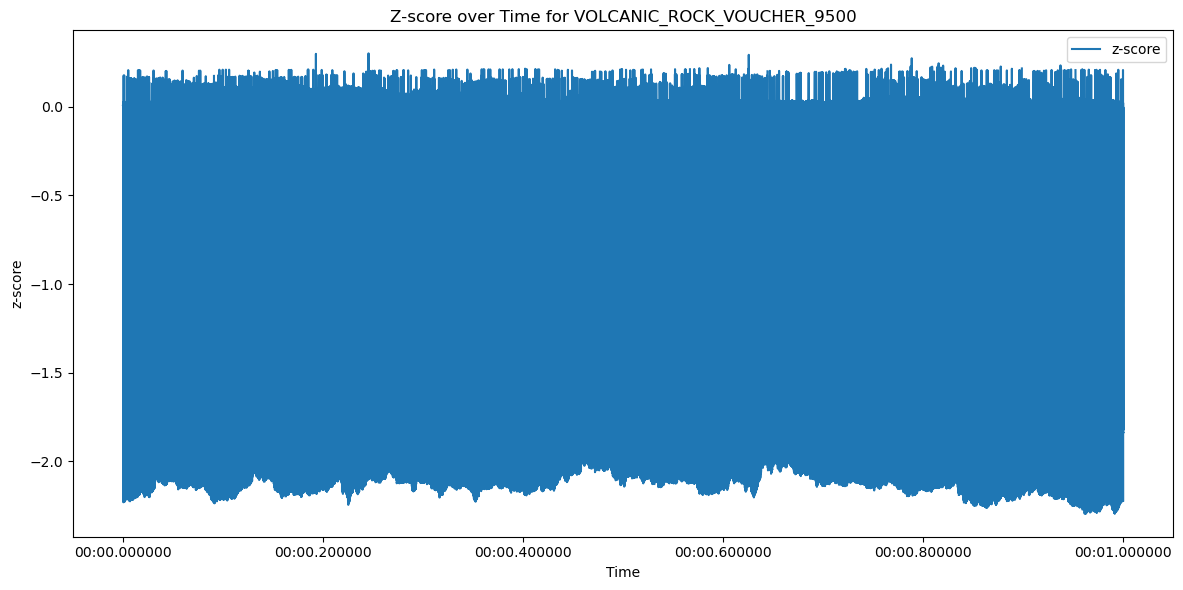

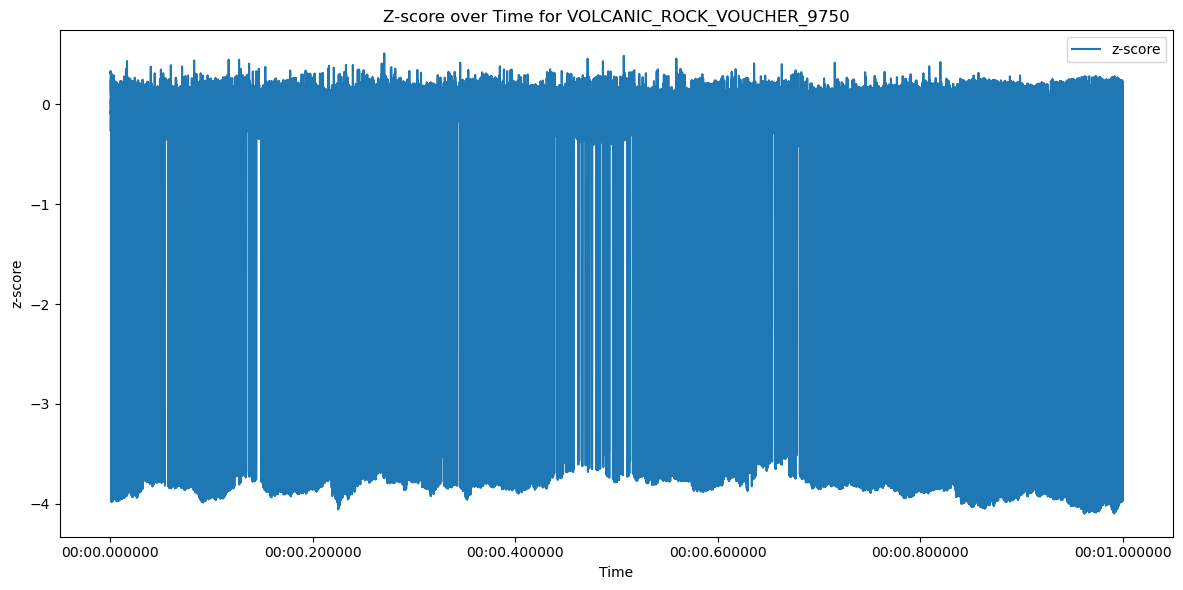

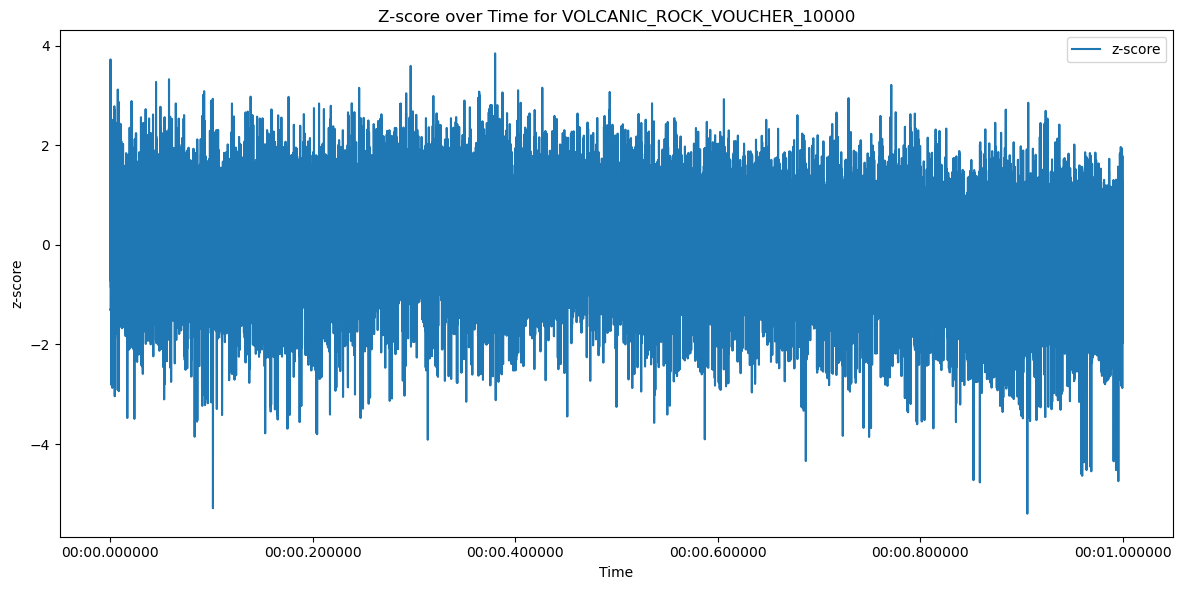

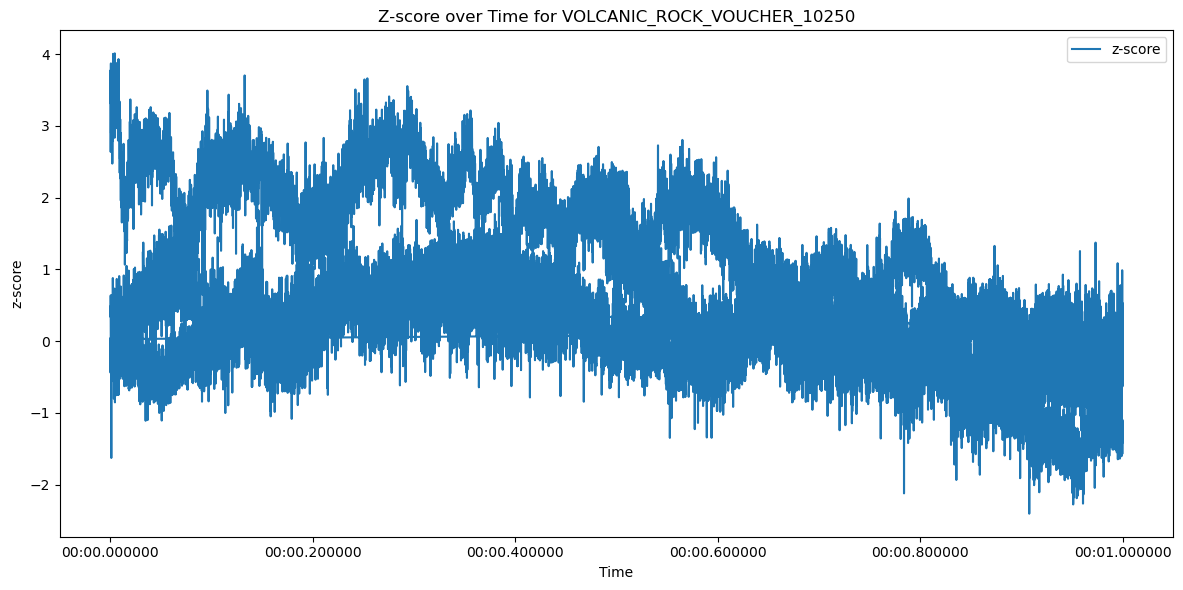

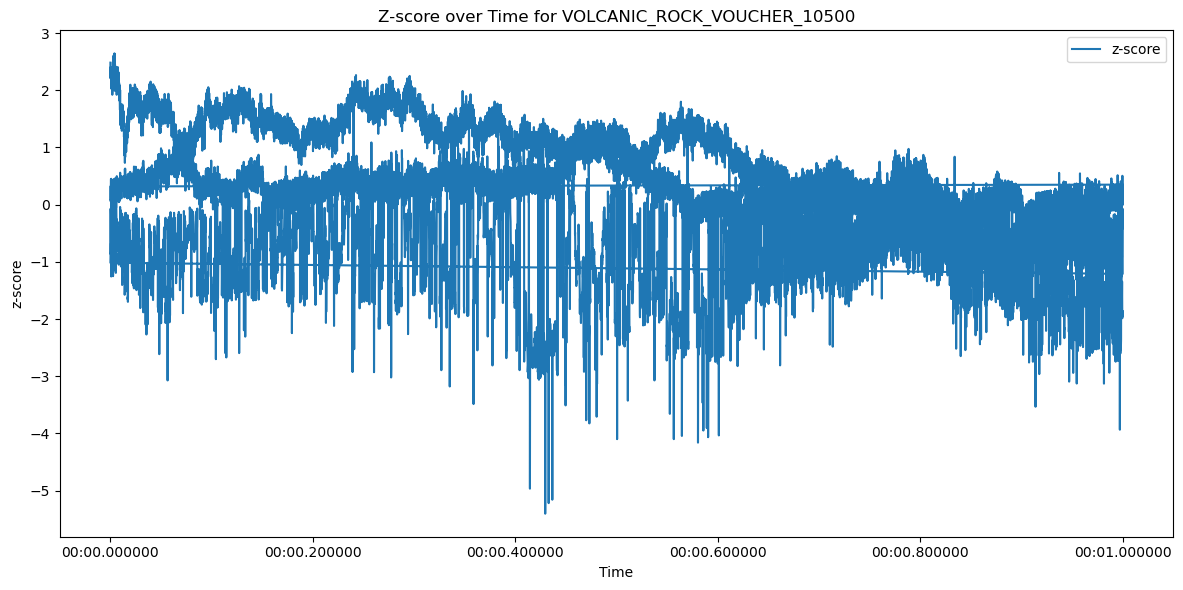

In [17]:
# -----------------------------
# 7. Plot 
# -----------------------------
for voucher_to_plot in voucher_strikes.keys():
    df_plot = voucher_dfs[voucher_to_plot].copy()
    df_plot["datetime"] = pd.to_datetime(df_plot["timestamp"], unit="us")  # adjust unit if needed
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot["datetime"], df_plot["z"], label="z-score")
    plt.title(f"Z-score over Time for {voucher_to_plot}")
    plt.xlabel("Time")
    plt.ylabel("z-score")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Param search 10k
buy_z_grid = np.arange(1, 3.5, 0.25) 
sell_z_grid = np.arange(1, 3.5, 0.25)
exit_z_grid = np.arange(0.1, 1, 0.1)   

best_params = {}
voucher = "VOLCANIC_ROCK_VOUCHER_10000"
df_v = voucher_dfs[voucher]
best, search_df = parameter_search_voucher(df_v, buy_z_grid, sell_z_grid, exit_z_grid)
best_params[voucher] = best
print(f"Voucher: {voucher}")
print(f"  Best Parameters: {best.to_dict()}")
print("-" * 40)

Voucher: VOLCANIC_ROCK_VOUCHER_10000
  Best Parameters: {'buy_z': 1.0, 'sell_z': 1.0, 'exit_z': 0.2, 'pnl': 12737.0}
----------------------------------------


In [32]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(search_df.sort_values(by='pnl', ascending=False))


    buy_z  sell_z  exit_z      pnl
0     1.0     1.0     0.2  12737.0
1     1.0     1.0     0.3  12695.0
2     1.0     1.0     0.4  12668.5
3     1.0     1.0     0.5  12619.0
20    1.5     1.0     0.2  10434.0
21    1.5     1.0     0.3  10378.0
22    1.5     1.0     0.4  10296.0
23    1.5     1.0     0.5  10292.5
4     1.0     1.5     0.2  10171.0
5     1.0     1.5     0.3  10067.0
6     1.0     1.5     0.4   9998.0
7     1.0     1.5     0.5   9926.5
40    2.0     1.0     0.2   9220.5
41    2.0     1.0     0.3   9174.0
42    2.0     1.0     0.4   9091.5
43    2.0     1.0     0.5   9046.5
60    2.5     1.0     0.2   8656.0
61    2.5     1.0     0.3   8600.0
62    2.5     1.0     0.4   8500.5
63    2.5     1.0     0.5   8444.0
80    3.0     1.0     0.2   8376.5
81    3.0     1.0     0.3   8337.0
82    3.0     1.0     0.4   8228.0
83    3.0     1.0     0.5   8146.0
8     1.0     2.0     0.2   8108.5
9     1.0     2.0     0.3   7971.5
10    1.0     2.0     0.4   7915.5
11    1.0     2.0   

In [33]:
df_v = voucher_dfs["VOLCANIC_ROCK_VOUCHER_10000"]
hist_std = df_v["delta_iv"].std()
print("Historical standard deviation (delta_iv):", hist_std)

Historical standard deviation (delta_iv): 0.006110812702837127
